# StyleCLIP

Редактирование изображений -- очень важная и интересная задача в мире генеративных моделей. В этом ноутбуке будем решать эту задачу на основе работы [StyleCLIP](https://arxiv.org/abs/2103.17249).

Данный метод позволяет редактировать изображения, сгенерированные [StyleGAN2](https://github.com/rosinality/stylegan2-pytorch), используя текстовые описания.
Например, можно взять фотографию человека и с помощью текстовой подсказки "сделать волосы кудрявыми" изменить прическу на фотографии. Основная идея данной работы в том, чтобы "подвинуть" изначальный латент так, чтобы сгенерированное из него изображение лучше соответствовало предложенному промпту.
Авторы предлагают два основных подхода:

- Оптимизация латентного вектора на основе CLIP Loss

- Обучение специального Mapper для сдвига

В данном ноутбуке реализован первый подход.
Ниже приведена иллюстрация, как работает оптимизация латентного вектора на основе CLIP Loss.




Наш план будет состоять в следующем:

1. Подготовка всех моделей для оптимизации

2. Реализация всех необходимых функций потерь:

  - CLIP Loss (1 балла)
  - ID Loss (1 балла)

3. Подготовка кода оптимизации (2 балла)

4. Выводы из полученных результатов (1 балл)

## Установка необходимых библиотек и подготовка окружения
Начнем с установки необходимых библиотек и клонирования репозитория StyleCLIP, чтобы использовать его методы.

In [ ]:
# Установка необходимых библиотек

# Установка зависимостей
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
# Установка дополнительных библиотек
!pip install Ninja

# Импорт нужных библиотек
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import save_image
import clip
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.0 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-hqmue_lp
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-hqmue_lp
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=5ea47207dfde300efc9ad7922c821a40f676ff0452b66af95f7927fab60aba41
  Stored in directory: /tmp/pip-ephem-wheel-cache-agrvrw8m/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 9.2 MB/s eta 0:00:00


In [ ]:
# Клонирование репозитория StyleGAN2
!git clone https://github.com/rosinality/stylegan2-pytorch.git

Cloning into 'stylegan2-pytorch'...
remote: Enumerating objects: 395, done.
remote: Total 395 (delta 0), reused 0 (delta 0), pack-reused 395 (from 1)
Receiving objects: 100% (395/395), 122.51 MiB | 31.35 MiB/s, done.
Resolving deltas: 100% (203/203), done.
Updating files: 100% (49/49), done.


In [ ]:
cd stylegan2-pytorch/

/content/stylegan2-pytorch


In [ ]:
# Будем работать с конкретным сидом
torch.manual_seed(345)

## Основная идея статьи


Как уже было сказано, мы хотим редактировать изображение с помощью текста. Для этого будем использовать [CLIP](https://paperswithcode.com/method/clip) модель для некоторого гайданса в процессе оптимизации.

Задачу мы хотим построить следующим образом: имея исходный латентный вектор $w \in W$ мы хотим оптимизировать его под текстовый запрос $t$. Подгрузим нашу модель и сгенерируем картинку для дальнейшей оптимизации.

Для работы со StyleGAN-2 нам для начала нужно скачать модель.

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# downloads StyleGAN's weights and facial recognition network weights
ids = ['1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT', '1N0MZSqPRJpLfP4mFQCS14ikrVSe8vQlL']
for file_id in ids:
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.FetchMetadata(fetch_all=True)
  downloaded.GetContentFile(downloaded.metadata['title'])

In [ ]:
# Зададим девайс: cuda или cpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Зададим сид
seed = 3456
torch.manual_seed(seed)

# Загрузка модели генератора StyleGAN2
from model import Generator
latent_dim = 512
generator = Generator(size=1024, style_dim=latent_dim, n_mlp=8).to(device)
state_dict = torch.load('/content/stylegan2-pytorch/stylegan2-ffhq-config-f.pt', map_location=device)
generator.load_state_dict(state_dict['g_ema'])
generator.eval()

print("Генератор StyleGAN2 загружены.")


/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
<ipython-input-6-3f0980f07b86>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`

Генератор StyleGAN2 загружены.


### Функция для генерации изображения из латентного вектора
Эта функция генерирует изображение из латентного вектора $z \in Z$ ($w \in W$), что нам пригодится для визуализации процесса редактирования.

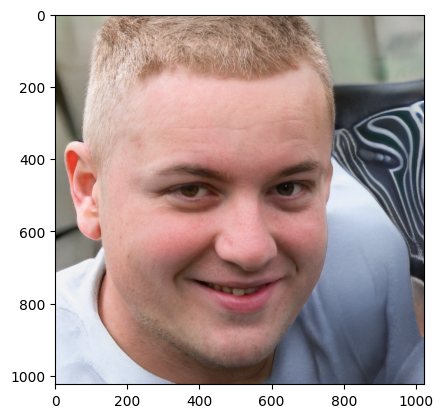

In [ ]:
# Сгенерируем изображение
latent_z = torch.randn(10000, 512, device=device) # Z noise
latent_z_generated = latent_z.mean(0, keepdim=True)

with torch.no_grad():
  target_img, _ = generator([latent_z_generated], input_is_latent=False)

plt.imshow((target_img.cpu().detach()[0].clip(-1,1).permute(1, 2, 0) + 1) / 2)

## Задача оптимизации

Нам необходимо следующее:

- Отредактированное изображение соответствует текстовому запросу

- Сохраняет identity изначального человека.

Авторы предлагают следующий лосс для оптимизации:

$$\arg \min_{w \in W} D_{\text{CLIP}}(G(w), t) + \lambda_2 \|w - w_s\|_2 + \lambda_{\text{ID}} L_{\text{ID}}(w)
$$

### CLIP loss

 $D_{\text{CLIP}}$ — косинусное расстояние между эмбеддингами [CLIP](https://habr.com/ru/articles/539312/) для двух аргументов.

$$D_{\text{CLIP}}(G(w), t) = 1 - \frac{\langle E_{\text{CLIP}}(G(w)) \cdot E_{\text{CLIP}}(t) \rangle }{\|E_{\text{CLIP}}(G(w))\| \cdot \|E_{\text{CLIP}}(t)\|}$$


In [ ]:
import torch
import clip


class CLIPLoss(torch.nn.Module):
    """
    Этот класс определяет пользовательскую функцию потерь на основе CLIP (Contrastive Language–Image Pre-training).
    Он измеряет сходство между изображением и текстовым описанием.
    """

    def __init__(self, stylegan_size=1024):
        """
        Инициализирует класс CLIPLoss.

        Args:
            opts: Объект, содержащий различные параметры, включая размер изображения StyleGAN.
        """
        super(CLIPLoss, self).__init__()
        # Загружаем предварительно обученную модель CLIP и функцию предварительной обработки
        self.model, self.preprocess = clip.load("ViT-B/32", device="cuda")

        self.upsample = torch.nn.Upsample(scale_factor=7)
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=stylegan_size // 32)

    def forward(self, image, text):
        """
        Вычисляет потери CLIP между изображением и текстом.

        Args:
            image: Входной тензор изображения.
            text: Тензор текстового описания.

        Returns:
            Значение потерь CLIP.
        """
        # Меняем размерность изображения для получения нужного разрешения для CLIP
        image = self.avg_pool(self.upsample(image))

        with torch.no_grad():
            image_features = self.model.encode_image(image) # получение эмбеддингов
            text_features = self.model.encode_text(text)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (image_features @ text_features.T).mean()

        return 1 - similarity

In [ ]:
clip_loss = CLIPLoss()

### ID loss

Для сохранения identity человека использует специально предобученную модель [ArcFace](https://arxiv.org/abs/1801.07698), которая по фотографии вычисляет некоторые характерные для человека embedding вектора. Затем нам необходимо посчитать косинусное расстояние между ожидаемым embedding вектором и тем, что получается в процессе оптимизации:

$$ L_{\text{ID}}(w) = 1 - \langle R(G(w_s)), R(G(w)) \rangle $$


### Подгрузка модели

Подгрузка самой модели, позаимствованная из репозитория [StyleCLIP](https://github.com/orpatashnik/StyleCLIP/blob/main/models/facial_recognition/helpers.py).


In [ ]:
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, Dropout, Sequential, Module

"""
Modified Backbone implementation from [TreB1eN](https://github.com/TreB1eN/InsightFace_Pytorch)
"""
from collections import namedtuple
import torch
from torch.nn import Conv2d, BatchNorm2d, PReLU, ReLU, Sigmoid, MaxPool2d, AdaptiveAvgPool2d, Sequential, Module

"""
ArcFace implementation from [TreB1eN](https://github.com/TreB1eN/InsightFace_Pytorch)
"""


class Flatten(Module):
	def forward(self, input):
		return input.view(input.size(0), -1)


def l2_norm(input, axis=1):
	norm = torch.norm(input, 2, axis, True)
	output = torch.div(input, norm)
	return output


class Bottleneck(namedtuple('Block', ['in_channel', 'depth', 'stride'])):
	""" A named tuple describing a ResNet block. """


def get_block(in_channel, depth, num_units, stride=2):
	return [Bottleneck(in_channel, depth, stride)] + [Bottleneck(depth, depth, 1) for i in range(num_units - 1)]


def get_blocks(num_layers):
	if num_layers == 50:
		blocks = [
			get_block(in_channel=64, depth=64, num_units=3),
			get_block(in_channel=64, depth=128, num_units=4),
			get_block(in_channel=128, depth=256, num_units=14),
			get_block(in_channel=256, depth=512, num_units=3)
		]
	elif num_layers == 100:
		blocks = [
			get_block(in_channel=64, depth=64, num_units=3),
			get_block(in_channel=64, depth=128, num_units=13),
			get_block(in_channel=128, depth=256, num_units=30),
			get_block(in_channel=256, depth=512, num_units=3)
		]
	elif num_layers == 152:
		blocks = [
			get_block(in_channel=64, depth=64, num_units=3),
			get_block(in_channel=64, depth=128, num_units=8),
			get_block(in_channel=128, depth=256, num_units=36),
			get_block(in_channel=256, depth=512, num_units=3)
		]
	else:
		raise ValueError("Invalid number of layers: {}. Must be one of [50, 100, 152]".format(num_layers))
	return blocks


class SEModule(Module):
	def __init__(self, channels, reduction):
		super(SEModule, self).__init__()
		self.avg_pool = AdaptiveAvgPool2d(1)
		self.fc1 = Conv2d(channels, channels // reduction, kernel_size=1, padding=0, bias=False)
		self.relu = ReLU(inplace=True)
		self.fc2 = Conv2d(channels // reduction, channels, kernel_size=1, padding=0, bias=False)
		self.sigmoid = Sigmoid()

	def forward(self, x):
		module_input = x
		x = self.avg_pool(x)
		x = self.fc1(x)
		x = self.relu(x)
		x = self.fc2(x)
		x = self.sigmoid(x)
		return module_input * x


class bottleneck_IR(Module):
	def __init__(self, in_channel, depth, stride):
		super(bottleneck_IR, self).__init__()
		if in_channel == depth:
			self.shortcut_layer = MaxPool2d(1, stride)
		else:
			self.shortcut_layer = Sequential(
				Conv2d(in_channel, depth, (1, 1), stride, bias=False),
				BatchNorm2d(depth)
			)
		self.res_layer = Sequential(
			BatchNorm2d(in_channel),
			Conv2d(in_channel, depth, (3, 3), (1, 1), 1, bias=False), PReLU(depth),
			Conv2d(depth, depth, (3, 3), stride, 1, bias=False), BatchNorm2d(depth)
		)

	def forward(self, x):
		shortcut = self.shortcut_layer(x)
		res = self.res_layer(x)
		return res + shortcut


class bottleneck_IR_SE(Module):
	def __init__(self, in_channel, depth, stride):
		super(bottleneck_IR_SE, self).__init__()
		if in_channel == depth:
			self.shortcut_layer = MaxPool2d(1, stride)
		else:
			self.shortcut_layer = Sequential(
				Conv2d(in_channel, depth, (1, 1), stride, bias=False),
				BatchNorm2d(depth)
			)
		self.res_layer = Sequential(
			BatchNorm2d(in_channel),
			Conv2d(in_channel, depth, (3, 3), (1, 1), 1, bias=False),
			PReLU(depth),
			Conv2d(depth, depth, (3, 3), stride, 1, bias=False),
			BatchNorm2d(depth),
			SEModule(depth, 16)
		)

	def forward(self, x):
		shortcut = self.shortcut_layer(x)
		res = self.res_layer(x)
		return res + shortcut


class Backbone(Module):
	def __init__(self, input_size, num_layers, mode='ir', drop_ratio=0.4, affine=True):
		super(Backbone, self).__init__()
		assert input_size in [112, 224], "input_size should be 112 or 224"
		assert num_layers in [50, 100, 152], "num_layers should be 50, 100 or 152"
		assert mode in ['ir', 'ir_se'], "mode should be ir or ir_se"
		blocks = get_blocks(num_layers)
		if mode == 'ir':
			unit_module = bottleneck_IR
		elif mode == 'ir_se':
			unit_module = bottleneck_IR_SE
		self.input_layer = Sequential(Conv2d(3, 64, (3, 3), 1, 1, bias=False),
									  BatchNorm2d(64),
									  PReLU(64))
		if input_size == 112:
			self.output_layer = Sequential(BatchNorm2d(512),
			                               Dropout(drop_ratio),
			                               Flatten(),
			                               Linear(512 * 7 * 7, 512),
			                               BatchNorm1d(512, affine=affine))
		else:
			self.output_layer = Sequential(BatchNorm2d(512),
			                               Dropout(drop_ratio),
			                               Flatten(),
			                               Linear(512 * 14 * 14, 512),
			                               BatchNorm1d(512, affine=affine))

		modules = []
		for block in blocks:
			for bottleneck in block:
				modules.append(unit_module(bottleneck.in_channel,
										   bottleneck.depth,
										   bottleneck.stride))
		self.body = Sequential(*modules)

	def forward(self, x):
		x = self.input_layer(x)
		x = self.body(x)
		x = self.output_layer(x)
		return l2_norm(x)


def IR_50(input_size):
	"""Constructs a ir-50 model."""
	model = Backbone(input_size, num_layers=50, mode='ir', drop_ratio=0.4, affine=False)
	return model


def IR_101(input_size):
	"""Constructs a ir-101 model."""
	model = Backbone(input_size, num_layers=100, mode='ir', drop_ratio=0.4, affine=False)
	return model


def IR_152(input_size):
	"""Constructs a ir-152 model."""
	model = Backbone(input_size, num_layers=152, mode='ir', drop_ratio=0.4, affine=False)
	return model


def IR_SE_50(input_size):
	"""Constructs a ir_se-50 model."""
	model = Backbone(input_size, num_layers=50, mode='ir_se', drop_ratio=0.4, affine=False)
	return model


def IR_SE_101(input_size):
	"""Constructs a ir_se-101 model."""
	model = Backbone(input_size, num_layers=100, mode='ir_se', drop_ratio=0.4, affine=False)
	return model


def IR_SE_152(input_size):
	"""Constructs a ir_se-152 model."""
	model = Backbone(input_size, num_layers=152, mode='ir_se', drop_ratio=0.4, affine=False)
	return model

### ID loss


In [ ]:
import torch
from torch import nn


class IDLoss(nn.Module):
    def __init__(self, model_weights, device='cuda'):
        super(IDLoss, self).__init__()
        print('Loading ResNet ArcFace')
        # Загружаем предобученную модель ResNet ArcFace для извлечения признаков лица.
        # input_size: размер входного изображения (112x112).
        self.facenet = Backbone(input_size=112, num_layers=50, drop_ratio=0.6, mode='ir_se')
        # Загружаем веса предобученной модели
        self.facenet.load_state_dict(torch.load(model_weights))
        self.pool = torch.nn.AdaptiveAvgPool2d((256, 256))
        self.face_pool = torch.nn.AdaptiveAvgPool2d((112, 112))
        self.facenet.eval()
        # Перемещаем модель ArcFace на GPU, если доступен.
        self.facenet.to(device)


    def extract_feats(self, x):
        # Функция для извлечения эмбеддингов лица из изображения x.
        # Если размер изображения не 256x256, изменяем его с помощью пулинга.
        if x.shape[2] != 256:
            x = self.pool(x)
        # Обрезаем центральную область изображения (35:223, 32:220), содержащую лицо.
        x = x[:, :, 35:223, 32:220]
        # Изменяем размер обрезанной области до 112x112 с помощью пулинга.
        x = self.face_pool(x)
        # Извлекаем эмбеддинги лица с помощью модели ArcFace.
        x_feats = self.facenet(x)
        # Возвращаем извлеченные эмбеддинги.
        return x_feats

    def forward(self, y_hat, y):
        # Функция для вычисления ID Loss.
        # y_hat: отредактированное изображение.
        # y: исходное изображение.
        n_samples = y.shape[0]
        # Извлекаем признаки лица из исходного изображения.
        y_features = self.extract_feats(y)

        # Извлекаем признаки лица из отредактированного изображения.
        y_hat_features = self.extract_feats(y_hat)

        # Считаем наш лосс
        loss = 1 - nn.functional.cosine_similarity(y_features, y_hat_features).mean()

        return loss

In [ ]:
# Загрузим нашу модель ArcFace
model_path = "/content/stylegan2-pytorch/model_ir_se50.pth"
id_loss = IDLoss(model_path, device)

Loading ResNet ArcFace


<ipython-input-69-756de0c7f698>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.facenet.load_state_dict(torch.load(model_weights))


In [ ]:
l2_loss = nn.MSELoss()

## Инициализация латентного вектора и текстовой подсказки
Определим латентный вектор
w для исходного изображения и преобразуем текстовую подсказку в вектор с помощью CLIP, что будет служить нашей целью для редактирования.

## Оптимизация для редактирования изображения
Реализуем оптимизацию, используя Adam. На каждом шаге обновляется латентный вектор $w \in W$ для минимизации потерь CLIP, пока результат не будет похож на текстовую подсказку.

Основной псевдокод оптимизации представлен ниже:

```python

for step in range(num_steps):  # <----------- итерируемся по датасету несколько раз
    torch.cuda.empty_cache() # <------------- очищаем кэш модели
    optimizer.zero_grad()  # <------------- обуляем градиенты модели
    image, _ = generator([latent], input_is_latent=True, randomize_noise=False)  # <------------- получаем картинку из StyleGAN-2
    loss = clip_loss + l2_lambda * l2_loss + id_lambda * id_loss
    loss.backward()  # <------------------- считаем градиенты
    optimizer.step()  # <------------------ делаем шаг градиентного спуска
    if convergence:  # <------------------- в случае сходимости выходим из цикла
        break
```

Где полная функция потерь считается по формуле:
$$\arg \min_{w \in W} D_{\text{CLIP}}(G(w), t) + \lambda_2 \|w - w_s\|_2 + \lambda_{\text{ID}} L_{\text{ID}}(w)
$$


In [ ]:
# Подготавливаем текстовый промпт для оптимизации, который будет направлять изменение изображения.
prompt = "a person with the beard"

# Токенизируем промпт с помощью CLIP tokenizer и перемещаем на устройство (CPU или GPU).
# clip.tokenize: функция из библиотеки CLIP для токенизации текста.
text_inputs = torch.cat([clip.tokenize(prompt)]).to(device)

In [ ]:
# Подготовим папку для сохранения результатов
import os
save_dir = "results"
os.makedirs(save_dir, exist_ok=True)

In [ ]:
# Получаем w-вектор из z-вектора с помощью mapping network генератора.
with torch.no_grad():
  latent_w = generator.style(latent_z_generated)

latent = latent_w.detach().clone()
latent.requires_grad = True

In [ ]:
%matplotlib inline

In [ ]:
# Оптимизация для редактирования с помощью CLIP

# Создадим оптимизатор Adam
optimizer = torch.optim.Adam([latent], lr=0.08)
# А также выберем скедулер
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)  # Плавное снижение скорости обучения

num_steps = 1000  # количество шагов оптимизации
l2_lambda = 0.008  # коэффициент для L2 регуляризации
id_lambda = 0.001  # коэффициент для identity loss


losses = {'id': [],
          'l2': [],
          'clip': [],
          'all': []
          }

for step in range(num_steps):
    torch.cuda.empty_cache()  # очищаем кэш модели
    # optimizer.zero_grad()  # обнуляем градиенты модели
    image, _ = generator([latent], input_is_latent=True, randomize_noise=False)  # получаем картинку из StyleGAN-2
    # вычисление потерь
    step_clip_loss = clip_loss.forward(image, text_inputs)
    step_l2_loss = l2_loss(latent, latent_w)
    step_id_loss = id_loss.forward(image, target_img)
    loss = step_clip_loss + l2_lambda * step_l2_loss + id_lambda * step_id_loss

    loss.backward()  # считаем градиенты
    optimizer.step()  # делаем шаг градиентного спуска
    scheduler.step() # шаг scheduler

    # сохранение потерь
    losses['id'].append(step_id_loss.item())
    losses['l2'].append(step_l2_loss.item())
    losses['clip'].append(step_clip_loss.item())
    losses['all'].append(loss.item())

    # Визуализация и вывод потерь
    if step % 50 == 0:  # Каждые 50 шагов
        print(f"inversion_generated_z/Step [{step}/{num_steps}], Loss: {losses['all'][-1]}")  # Вывод текущих потерь
        fig, axs = plt.subplots(1, 2, figsize=(16, 32))  # Создание подграфиков для визуализации

        # Визуализация сгенерированного изображения
        axs[0].imshow((image.cpu().detach()[0].clip(-1,1).permute(1, 2, 0) + 1) / 2)
        axs[0].set_title("Сгенерированное изображение")  # Заголовок для сгенерированного изображения
        axs[0].axis('off')  # Отключение осей

        # Визуализация целевого изображения
        axs[1].imshow((target_img.cpu().detach()[0].clip(-1,1).permute(1, 2, 0) + 1) / 2)
        axs[1].set_title("Целевое изображение")  # Заголовок для целевого изображения
        axs[1].axis('off')  # Отключение осей
        plt.show()

Чтобы не загромождать файл множеством картинок, покажем финальное сгенерированное изображение на последнем шаге

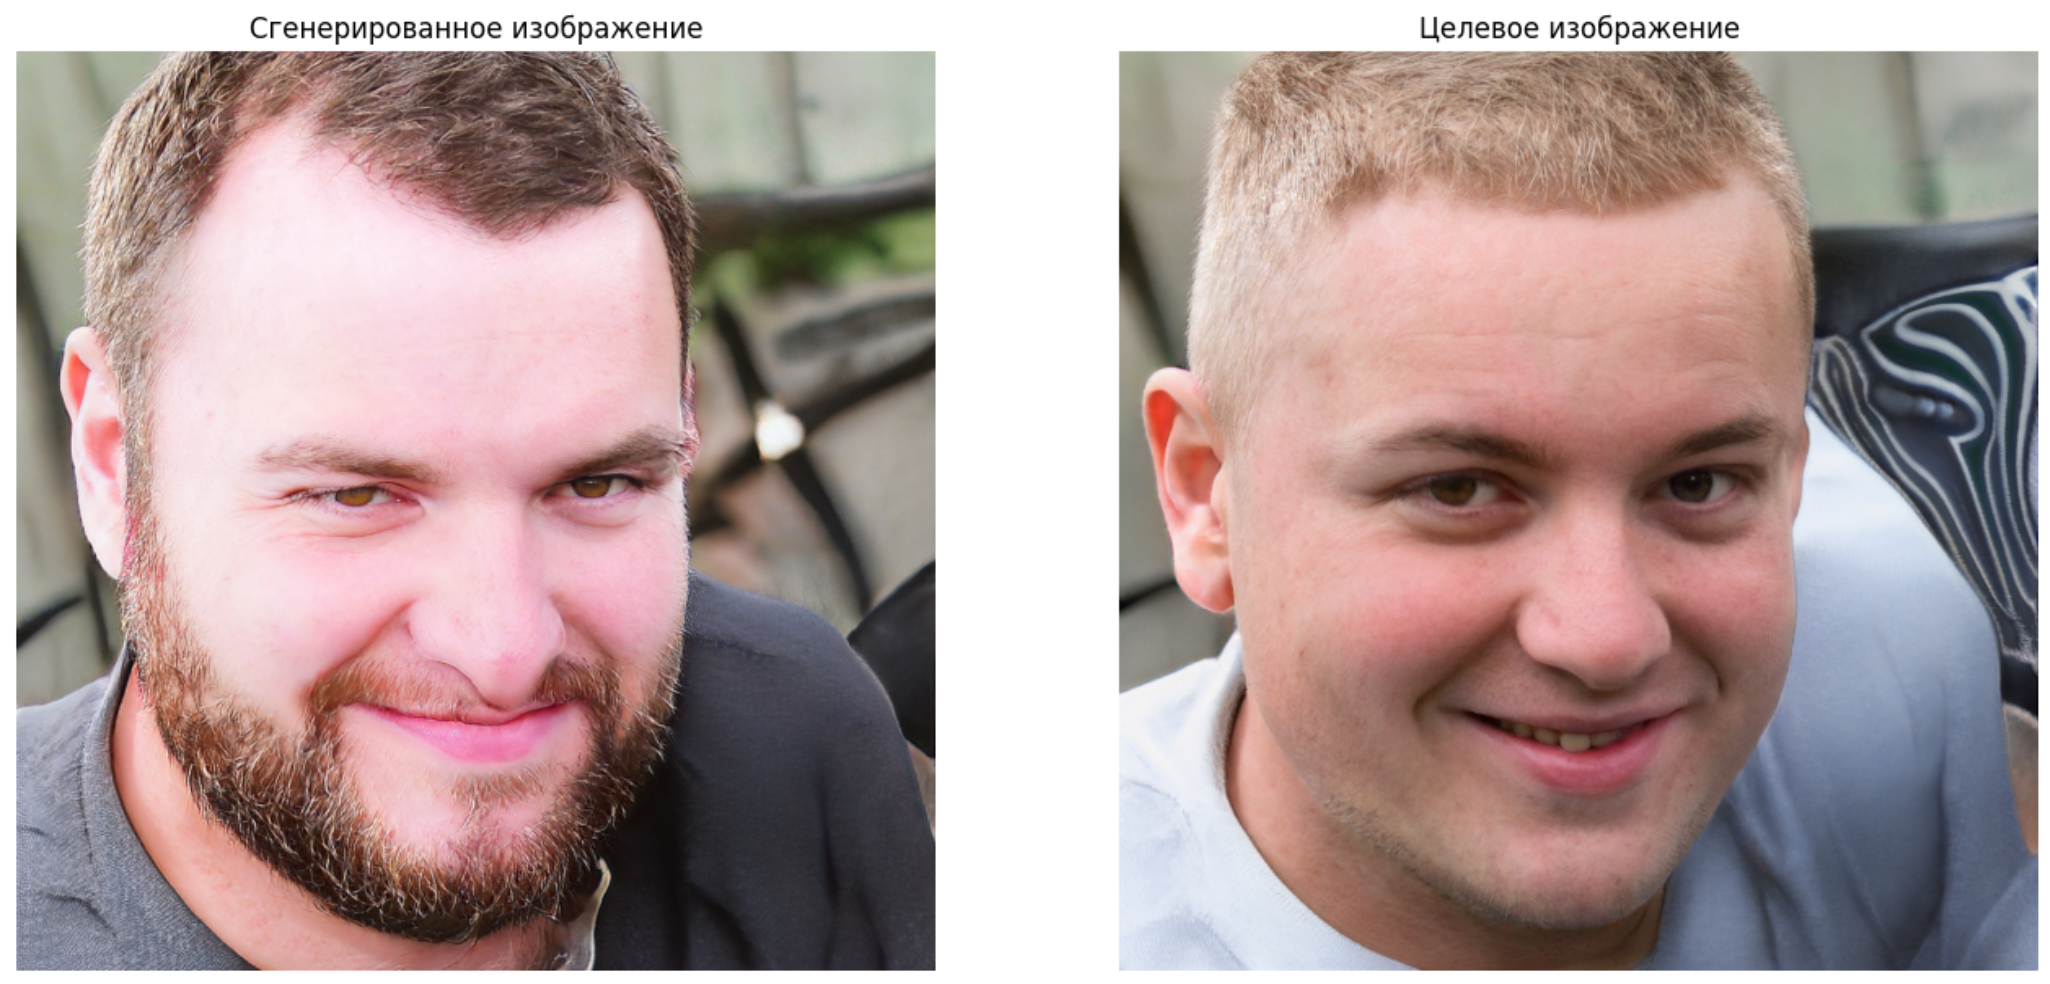

Визуализация лоссов в зависимости от step

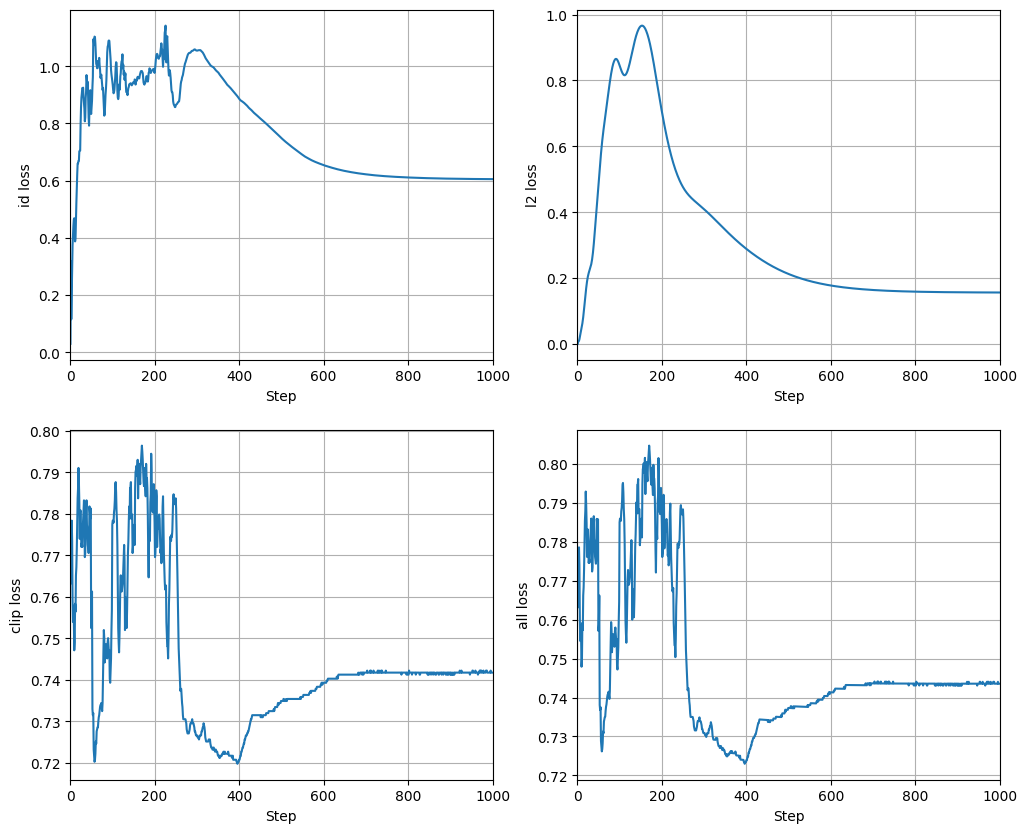

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes = axes.flatten()

for i, (loss_name, loss_values) in enumerate(losses.items()):
    axes[i].plot(range(1, num_steps + 1), loss_values, label=loss_name)
    axes[i].set_xlim(0, 1000)
    axes[i].set_xlabel('Step')
    axes[i].set_ylabel(f'{loss_name} loss')
    axes[i].grid(True)


Сохранение результатов

In [ ]:
import os

filename = prompt

# Save the latents to a .pt file.
latent_path = os.path.join(save_dir, filename + ".pt")
torch.save(latent, latent_path)

# Save the image to a .png file.
image_path = os.path.join(save_dir, filename + ".png")
save_image(image, image_path)


print(f"Изображение и латенты успешно сохранены в папке {save_dir}")

Ваше изображение и латенты успешно сохранены в папке results


### Выводы

Сравнивания итоговое сгенерированное изображение с исходным мы видим, что был выполнен запрос "сделать человека с бородой", однако получившийся человек несколько отличается от исходного. Например, у него другая форма глаз, отличается причёска, также есть другие внешние отличия. Однако сохранилось положение головы и овал лица, то есть более высокоуровневые признаки. Считаю, что при увеличении количества итераций результат не станет сильно лучше при сохранении того же подхода оптимизации, возможно, следует пробовать другие подходы.

Также стоит отметить, что несмотря на некоторые различия
исходного и изменённого по промту изображений, функция потерь уменьшилась по сравнению с первоначальной и вышла на некоторое константное значение начиная с 600 итерации, то есть была достигнута сходимость.